In [ ]:

import pandas as pd
import numpy as np

df = pd.read_csv('C:\\Users\\mooda\\OneDrive\\Desktop\\superstore_sales.csv')

print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())
df = df.dropna(subset=['Order ID', 'Customer ID', 'Product ID', 'Sales', 'Postal Code'])

print("\nDuplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y', errors='coerce')

categorical_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()

df['Sales'] = df['Sales'].astype(float)
df['Postal Code'] = df['Postal Code'].astype(int)

Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]
print("\nNumber of Sales Outliers:", len(outliers))
df['Sales'] = df['Sales'].clip(lower=lower_bound, upper=upper_bound)

for col in categorical_cols:
    print(f"\nUnique values in {col}:", df[col].unique())
df['Ship Mode'] = df['Ship Mode'].replace({'Second Class': 'Second Class', 'Standard Class': 'Standard Class', 'First Class': 'First Class', 'Same Day': 'Same Day'})

invalid_dates = df[df['Ship Date'] < df['Order Date']]
print("\nInvalid Ship Dates (Ship Date < Order Date):", len(invalid_dates))
df = df[df['Ship Date'] >= df['Order Date']]

df.to_csv('superstore_sales_cleaned.csv', index=False)
print("\nCleaned dataset saved as 'superstore_sales_cleaned.csv'")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns



print("Missing Values:")
print(df.isnull().sum())


df = df.dropna(subset=['Order ID', 'Customer ID', 'Product ID', 'Sales', 'Postal Code'])


df = df.drop_duplicates()


df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y', errors='coerce')


df = df[df['Ship Date'] >= df['Order Date']]


df['Shipping Duration'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Customer Order Count'] = df.groupby('Customer ID')['Order ID'].transform('count')


df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Ship Year'] = df['Ship Date'].dt.year
df['Ship Month'] = df['Ship Date'].dt.month
df['Ship Day'] = df['Ship Date'].dt.day


df = df.drop(['Order Date', 'Ship Date', 'Row ID', 'Order ID', 'Customer Name', 'Product ID', 'Product Name'], axis=1)


categorical_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
numerical_cols = ['Postal Code', 'Order Year', 'Order Month', 'Order Day', 'Ship Year', 'Ship Month', 'Ship Day', 'Shipping Duration', 'Customer Order Count']


sales_median = df['Sales'].median()
df['High_Sales'] = (df['Sales'] > sales_median).astype(int)
X = df.drop(['Sales', 'High_Sales', 'Customer ID'], axis=1)
y = df['High_Sales'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])


X_temp, _, y_temp, _ = train_test_split(X, y, train_size=1000, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=66, stratify=y_temp, random_state=42)


test_df = pd.DataFrame(X_test).copy()
test_df['High_Sales'] = y_test
class_0 = test_df[test_df['High_Sales'] == 0]
class_1 = test_df[test_df['High_Sales'] == 1]
class_0_sampled = resample(class_0, n_samples=51, random_state=42)
class_1_sampled = resample(class_1, n_samples=15, random_state=42)
test_df_balanced = pd.concat([class_0_sampled, class_1_sampled])
X_test = test_df_balanced.drop('High_Sales', axis=1)
y_test = test_df_balanced['High_Sales']


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42))
])


rf_pipeline.fit(X_train, y_train)


y_pred_rf = rf_pipeline.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)


print("\nRandom Forest Performance:")
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"Accuracy: {accuracy_rf:.12f}")
print("Classification Report:")
print(class_report_rf)

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=1, epsilon=0.1))
])


svr_pipeline.fit(X_train, df.loc[X_train.index, 'Sales'])


y_pred_svr = svr_pipeline.predict(X_test)


y_pred_svr_binary = (y_pred_svr > sales_median).astype(int)

conf_matrix_svr = confusion_matrix(y_test, y_pred_svr_binary)
accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
class_report_svr = classification_report(y_test, y_pred_svr_binary)

print("\nSVR Performance:")
print("Confusion Matrix:")
print(conf_matrix_svr)
print(f"Accuracy: {accuracy_svr:.12f}")
print("Classification Report:")
print(class_report_svr)


knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_test)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)

print("\nKNN Performance:")
print("Confusion Matrix:")
print(conf_matrix_knn)
print(f"Accuracy: {accuracy_knn:.12f}")
print("Classification Report:")
print(class_report_knn)


X_preprocessed = preprocessor.fit_transform(X)
preprocessed_columns = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
df_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessed_columns)
df_preprocessed['High_Sales'] = y.reset_index(drop=True)
df_preprocessed.to_csv('superstore_sales_preprocessed_combined.csv', index=False)
print("\nPreprocessed dataset saved as 'superstore_sales_preprocessed_combined.csv'")
print("Random Forest confusion matrix saved as 'rf_confusion_matrix.png'")
print("SVR confusion matrix saved as 'svr_confusion_matrix.png'")
print("KNN confusion matrix saved as 'knn_confusion_matrix.png'")

Missing Values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64


C:\Users\mooda\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\mooda\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\mooda\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Random Forest Performance:
Confusion Matrix:
[[47  4]
 [ 5 10]]
Accuracy: 0.863636363636
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        51
           1       0.71      0.67      0.69        15

    accuracy                           0.86        66
   macro avg       0.81      0.79      0.80        66
weighted avg       0.86      0.86      0.86        66


SVR Performance:
Confusion Matrix:
[[45  6]
 [ 5 10]]
Accuracy: 0.833333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        51
           1       0.62      0.67      0.65        15

    accuracy                           0.83        66
   macro avg       0.76      0.77      0.77        66
weighted avg       0.84      0.83      0.84        66


KNN Performance:
Confusion Matrix:
[[49  2]
 [ 8  7]]
Accuracy: 0.848484848485
Classification Report:
              precision    

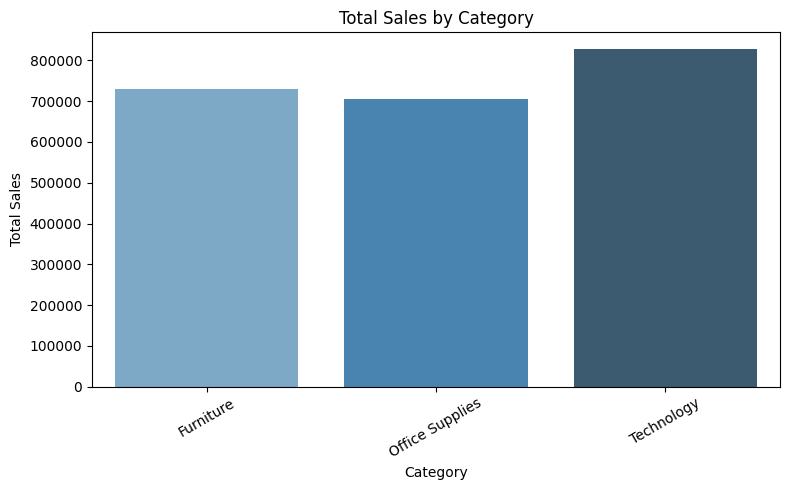

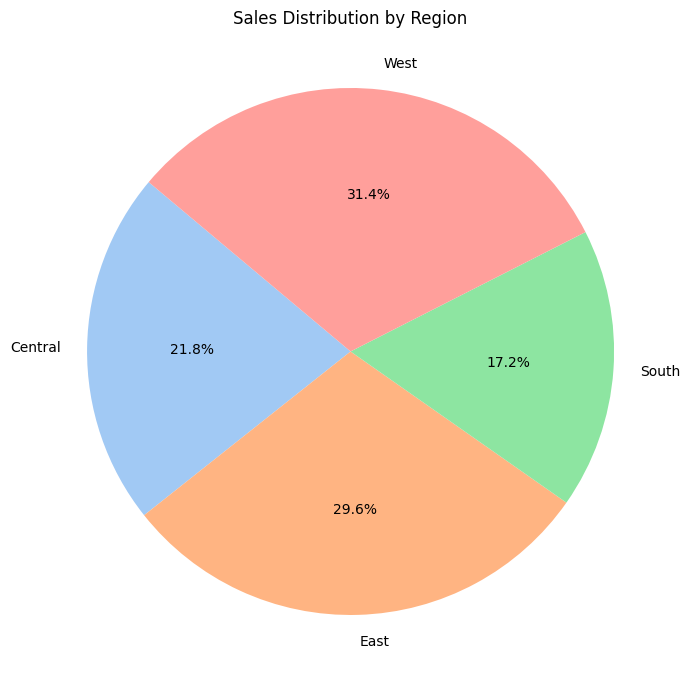

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

category_sales = df.groupby('Category')['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=category_sales, x='Category', y='Sales', hue='Category', palette='Blues_d', legend=False)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


region_sales = df.groupby('Region')['Sales'].sum()

plt.figure(figsize=(7, 7))
plt.pie(region_sales, labels=region_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Sales Distribution by Region')
plt.axis('equal')  
plt.tight_layout()
plt.show()

